# Import dependencies

In [1]:
# Import libraries
import numpy as np
from os import path
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
# get current directory
dir = path.dirname(path.abspath('__file__'))

# Functions to import raw data

In [3]:
# define function to create dataframe from png files
def create_image_dataframe(png_pattern):
    # get a list of all file matches
    png_files = glob.glob(png_pattern)

    # initiate objects
    data_df = pd.DataFrame()
    image_list = []
    image_path_list = []
    sequence_list = []
    image_number_list = []

    # read in files
    for image_path in png_files:
        # store image path in a list
        image_path_list.append(image_path)
        
        # get file name from file path
        image = path.basename(image_path)
        image_list.append(image)
        
        # get sequence number from file name
        sequence = image[:8]
        sequence_list.append(sequence)
        # get image number for each sequence
        image_number = int(image[9:-4])
        image_number_list.append(image_number)
              
    # convert lists to Pandas series
    image_list = pd.Series(image_list)
    image_path_list = pd.Series(image_path_list)
    sequence_list = pd.Series(sequence_list)
    image_number_list = pd.Series(image_number_list)
    
    # Join Pandas Series in a data frame
    data_df = pd.concat([image_list, image_path_list, sequence_list, image_number_list], axis=1 , ignore_index= True)
    data_df.columns = ['image','image_path', 'sequence', 'image_number']
    return data_df

In [4]:
# define function to create a dictionary of emotion labels for sequences
def create_sequence_to_emotion_dict(txt_pattern): 
    # get a list of all file matches
    txt_files = glob.glob(txt_pattern)

    # initiate empty list
    emotion_dict = {}

    # read in files
    for txt_filepath in txt_files:
        # get file name from file path
        txt_filename = path.basename(txt_filepath)
        # get sequence number from file name
        sequence = txt_filename[:8]
        # get the emotion category from text file
        value = int(eval(open(txt_filepath, 'r').read()))
        # store emotion using the sequence as the key in the dictionary
        emotion_dict[sequence] = value
    return(emotion_dict)

# Functions to merge and clean data 

In [5]:
# define function to match emotion labels with the images 
def label_sequences(data_df, emotion_dict): 
    data_df['emotion'] = data_df['sequence'].map(emotion_dict)
    return data_df

In [6]:
# define function clean up dataframe 
def clean_image_df(data_df):
    # Number of images in full dataset 
    print('Total images: ', str(data_df.shape[0]) )
    print('Total sequences: ', str(len(data_df.sequence.unique())) )

    # Number of labelled images in full dataset 
    dropped_df = data_df.dropna(how='any', axis='rows')
    print('Labelled images: ', str(dropped_df.shape[0]) )
    print('Total labelled sequences: ', str(len(dropped_df.sequence.unique())) )

    # Label first 4 images in sequences to be a neutral face
    dropped_df.loc[ dropped_df['image_number'] < 5, 'emotion' ] = 0
    
    # Set emotions as categories 
    dropped_df['emotion'] = dropped_df['emotion'].astype('int').astype('category')
    
    # reset index
    dropped_df = dropped_df.reset_index(drop=True)
    
    return dropped_df

In [7]:
# define function to get CK+ images and labels into a clean dataframe
def get_labelled_images(): 
    # Write patterns for images and emotion labels 
    png_pattern = '../01_raw_data/CK+/cohn-kanade-images/**/**/*.png'
    txt_pattern = '../01_raw_data/CK+/Emotion/**/**/*.txt'

    # get images
    data_df = create_image_dataframe(png_pattern)
    
    # get emotion labels
    emotion_dict = create_sequence_to_emotion_dict(txt_pattern)
    
    # label images
    labelled_data = label_sequences(data_df, emotion_dict)
    
    # clean df
    clean_df = clean_image_df(labelled_data)
    
    return clean_df

# Execute data extraction and cleaning

In [8]:
# execute getting labelled images    
clean_df = get_labelled_images()

Total images:  10708
Total sequences:  593
Labelled images:  5876
Total labelled sequences:  327


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# Exploration of dataset 

In [9]:
# explore dataset
for emotion in range(0,8):
    emotion_df = clean_df[ clean_df['emotion'] == emotion ]
    print('Emotion :', str(emotion) )
    print('Total images: ', str(emotion_df.shape[0]) )
    print('Total sequences: ', str(len(emotion_df.sequence.unique())) )
    print('-----------------')

Emotion : 0
Total images:  1308
Total sequences:  327
-----------------
Emotion : 1
Total images:  842
Total sequences:  45
-----------------
Emotion : 2
Total images:  161
Total sequences:  18
-----------------
Emotion : 3
Total images:  632
Total sequences:  59
-----------------
Emotion : 4
Total images:  446
Total sequences:  25
-----------------
Emotion : 5
Total images:  1055
Total sequences:  69
-----------------
Emotion : 6
Total images:  435
Total sequences:  28
-----------------
Emotion : 7
Total images:  997
Total sequences:  83
-----------------


## Preview first sequence of images

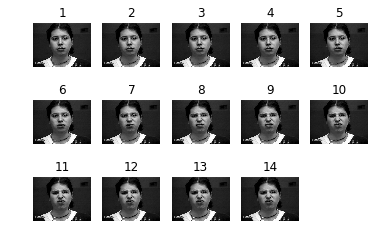

In [10]:
first_sequence = clean_df.loc[ clean_df.sequence == clean_df.iloc[0]['sequence']].sort_values(by='image_number')

i = 0
for imagePath in first_sequence.image_path:  
    image = cv2.imread(imagePath)
    i += 1
    plt.subplot(3, 5, i)
    plt.axis('off')
    plt.title(i)
    plt.imshow(image)
plt.show()

The emotions have labels ranging from 0 to 7. (where 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise). 

The images show that for the first 4-6 images in this sequence, the facial expression is fairly neutral. It is only later in the sequence ~ 7 to 8 where the expression of disgust becomes more evident. 

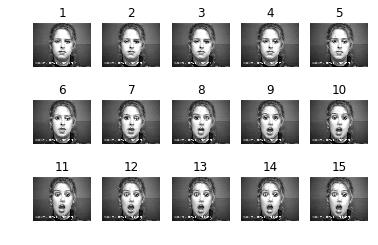

In [16]:
second_sequence = clean_df.loc[ clean_df.sequence == 'S052_001'].sort_values(by='image_number')

i = 0
for imagePath in second_sequence.image_path:  
    image = cv2.imread(imagePath)
    i += 1
    plt.subplot(3, 5, i)
    plt.axis('off')
    plt.title(i)
    plt.imshow(image)
plt.show()

In [12]:
second_sequence

,image,image_path,sequence,image_number,emotion


In [12]:
first_sequence

,image,image_path,sequence,image_number,emotion
10,S111_007_00000001.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,1,0
12,S111_007_00000002.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,2,0
13,S111_007_00000003.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,3,0
6,S111_007_00000004.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,4,0
9,S111_007_00000005.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,5,3
4,S111_007_00000006.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,6,3
3,S111_007_00000007.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,7,3
0,S111_007_00000008.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,8,3
1,S111_007_00000009.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,9,3
7,S111_007_00000010.png,../01_raw_data/CK+/cohn-kanade-images/S111/007...,S111_007,10,3


# Save dataframe

In [13]:
# Save df into a csv 
filename_out = path.join(dir, '..' ,'04_processed_data','labelled_images.csv')
clean_df.to_csv(filename_out, index=False )

## Verify saved df

In [14]:
# Load df from a csv 
loaded_df = pd.read_csv(filename_out, index_col = False)
loaded_df['emotion'] = loaded_df['emotion'].astype('category')

In [17]:
from pandas.util.testing import assert_frame_equal
assert_frame_equal(clean_df, loaded_df)